<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/otimiza%C3%A7%C3%A3o_caraga_caminh%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# **Otimização de Cargas com Algoritimo Genéticos**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_f77572eb85d049688987c967d9038104~mv2.jpg"></p>




In [ ]:
!pip install deap -q

     |████████████████████████████████| 163kB 14.3MB/s 


In [ ]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, algorithms, tools
import matplotlib.pyplot as plt
import seaborn as sns

#configurações de gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Importando os dados

In [ ]:
!pip install kaggle -q

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

 59% 25.0M/42.7M [00:00<00:00, 23.1MB/s]
100% 42.7M/42.7M [00:00<00:00, 46.3MB/s]


In [ ]:
!ls

brazilian-ecommerce.zip  kaggle.json  sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
df_items = pd.read_csv('/content/files/olist_order_items_dataset.csv')
df_produto = pd.read_csv('/content/files/olist_products_dataset.csv')

In [ ]:
print(df_items.shape)
df_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
print(df_produto.shape)
df_produto.head()

(32951, 6)


,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


### Prepararo do dataset

In [ ]:
#Escolher variáleis as necesárias
df_items = df_items.iloc[:, [2,5,6]]
df_produto = df_produto.iloc[:, [0,1,5,6,7,8]]

In [ ]:
#Indexar o id do produto
df_items = df_items.set_index('product_id')
df_produto = df_produto.set_index('product_id')

In [ ]:
 #Realizar um join entre as tabelas
 df = df_items.join(df_produto)

In [ ]:
#Calcular o volume e preço total de cada produto
df["volume"] = df["product_length_cm"]*df["product_height_cm"]*df["product_width_cm"]
df["preco"] =  df["price"]+df["freight_value"]
df = df.reset_index()

In [ ]:
#Escolher dataset final
produtos = df.iloc[:, [0,3, 4 ,8,9]]
produtos.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50


## Criando o Algoritimo Genético

Tipo de caminhão VUC
<p align="center"><img src="http://www.guiadotrc.com.br/figuras/vuc-reforcado.gif?gtgggf"></p>



<p align="center"><img src="https://www.truckpad.com.br/uploads/2017/01/329981fc-medidas-carrocerias-3.png"></p>

In [ ]:
#lmimte de espaço no caminhão
limtie_espacos = 2.2*7.2*3.5*100  #grandeza em centimetros
limtie_peso = 4e+6   #grandeza em gramas

In [ ]:
#Criar Classe do Produto
class Produto():
    def __init__(self, nome, pesos, volume, valores):
        self.nome = nome
        self.pesos = pesos 
        self.volume = volume
        self.valor = valor

In [ ]:
#Criando listas de produtos
lista_produtos = []

for i in range(len(produtos)):
  lista_produtos.append(produtos.loc[i])

In [ ]:
#Transformar em listas
espacos = list(produtos.volume)
valores = list(produtos.preco)
nome = list(produtos.product_id)
pesos = list(produtos.product_weight_g)

In [ ]:
#Criar a função de avaliação
def avaliacao(individual):
    nota = 0 
    soma_espacos = 0
    soma_pesos = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            nota += valores[i]
            soma_espacos += espacos[i]
            soma_pesos += pesos[i]
            
    if soma_espacos > limtie_espacos and soma_pesos > limtie_peso:
      nota = 1

    return nota / 100000, 

In [ ]:
#Criar a toolbox
toolbox = base.Toolbox()

#Criando parâmetros na toolbox
creator.create("FitnessMax",  base.Fitness, weights = (1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMax)

#Registrando na toolbox
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selRoulette)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
#Iniciando a toolbox
if __name__ == "__main__":
    population = toolbox.population(n = 25)
    probabilidade_crossover = 1.0
    probabilidade_mutação = 0.03
    numero_gerações = 250
    
    estatisticas = tools.Statistics( key = lambda individuo: individuo.fitness.values)
    estatisticas.register("max", np.max)
    estatisticas.register("min", np.min)
    estatisticas.register("med", np.mean)
    estatisticas.register("std", np.std)
    
    populacao, info = algorithms.eaSimple(population, toolbox, 
                                          probabilidade_crossover, 
                                          probabilidade_mutação,
                                          numero_gerações, estatisticas)

gen	nevals	max    	min    	med    	std     
0  	25    	79.7944	78.2896	79.2876	0.371402
1  	24    	79.8643	78.2896	79.186 	0.365236
2  	24    	80.2109	78.5556	79.1805	0.365251
3  	24    	79.7509	78.6029	79.2424	0.328178
4  	24    	79.7792	78.5828	79.3426	0.299677
5  	24    	79.8127	78.8723	79.3466	0.236362
6  	24    	79.9476	78.9296	79.3656	0.218191
7  	24    	79.8604	78.4893	79.3369	0.280012
8  	24    	79.8437	78.883 	79.3804	0.23262 
9  	24    	79.8437	78.6182	79.327 	0.249222
10 	24    	79.8437	78.825 	79.3847	0.277061
11 	24    	79.8075	78.7612	79.3875	0.264474
12 	24    	79.7933	78.9399	79.3552	0.222219
13 	24    	79.6845	78.7612	79.285 	0.249896
14 	24    	79.7575	78.6697	79.2326	0.287975
15 	24    	79.7138	78.6765	79.2986	0.298294
16 	24    	79.9068	78.6489	79.2547	0.330859
17 	24    	79.6497	78.6783	79.2203	0.294788
18 	24    	79.6162	78.6191	79.2382	0.28465 
19 	24    	79.6162	78.7823	79.3218	0.212632
20 	24    	79.9009	78.7163	79.2912	0.271411
21 	24    	79.8324	78.7964	79.28

In [ ]:
#Identificando o melhor indivíduo
melhores = tools.selBest(populacao, 1)

for individuo in melhores:

    df_otimizado = []
    soma = 0
    indi = 0
    for i in range (len(lista_produtos)):
        if individuo[i] == 1:
            soma += valores[i]
            indi += individuo[i]
            df_otimizado.append(lista_produtos[i])

    print("---")
    print("Valor total do Indivíduo: R$", soma)
    print("Número Indivíduo:", indi)

---
Valor total do Indivíduo: R$ 7958484.079999713
Número Indivíduo: 56361


In [ ]:
df_otimizado = pd.DataFrame(df_otimizado)
df_otimizado.head()

,product_id,product_category_name,product_weight_g,volume,preco
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
11,001795ec6f1b187d37335e1c4704762e,consoles_games,600.0,12000.0,48.24
12,001795ec6f1b187d37335e1c4704762e,consoles_games,600.0,12000.0,55.01
14,001795ec6f1b187d37335e1c4704762e,consoles_games,600.0,12000.0,48.24


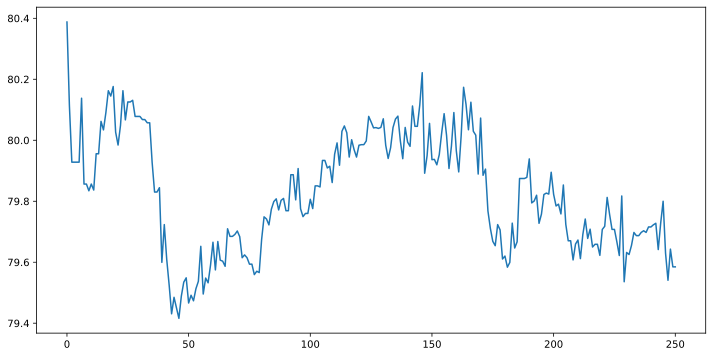

In [ ]:
#Plotando o aprendizado
valores_pop = info.select("max")
plt.figure(figsize = (12,6))
plt.plot(valores_pop)
plt.show()